In [168]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
import tensorflow as tf
from tensorflow.keras.layers import (
    LSTM, GRU, SimpleRNN, Bidirectional, Conv1D, GlobalMaxPooling1D,
    Activation, Dense, Dropout, Input, Embedding, BatchNormalization,
    Add, LayerNormalization, MultiHeadAttention
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
# Download NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from tensorflow.keras.models import load_model
from wordcloud import WordCloud #library that creates a visualization of the most frequently occurring words.
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Activation, Dropout
from tensorflow.keras.optimizers import RMSprop

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Study Data

In [2]:
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")
df.columns = ["label", "time", "date", "query", "username", "text"]
df

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [4]:
df.describe()

,label,time
count,1.599999e+06,1.599999e+06
mean,2.000001e+00,1.998818e+09
std,2.000001e+00,1.935757e+08
min,0.000000e+00,1.467811e+09
25%,0.000000e+00,1.956916e+09
50%,4.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [5]:
df['label'].value_counts()

label
4    800000
0    799999
Name: count, dtype: int64

In [3]:
# Convert labels (4 -> 1, 0 -> 0)
df['label'] = df['label'].apply(lambda x: 1 if x == 4 else 0)

df['label'].value_counts()

label
1    800000
0    799999
Name: count, dtype: int64

# Pre-Clean Text Word Cloud Combination

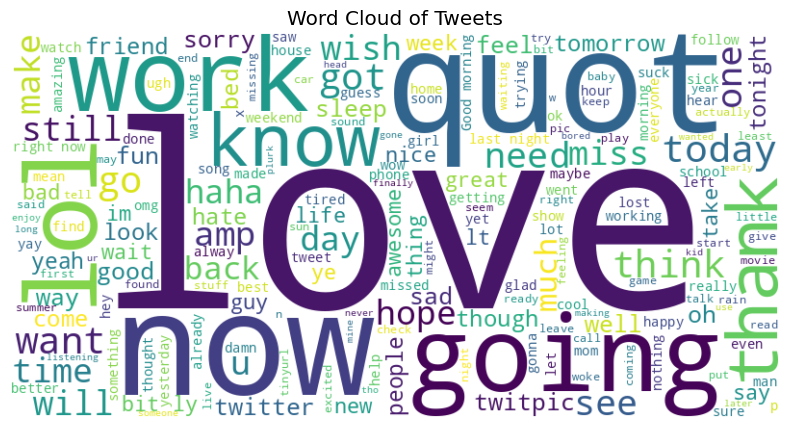

In [166]:
from wordcloud import WordCloud #library that creates a visualization of the most frequently occurring words.
import matplotlib.pyplot as plt

# Combine all the cleaned texts into one string
all_text = ' '.join(df['text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for the word cloud
plt.title('Word Cloud of Tweets')
plt.show()

# Models Without Preprocessing

# Tokenization and padding

In [5]:

max_words = 2000
max_len = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
X = sequence.pad_sequences(sequences, maxlen=max_len)#Ensures all sequences have the same length (max_len) by adding padding.
y = df['label'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM-based-model

In [6]:
def lstm_based_model():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(2000,50,input_length=max_len)(inputs) 
    layer = LSTM(64)(layer) 
    layer = Dense(256,name='FC1')(layer) 
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer) 
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer) 
    model = Model(inputs=inputs,outputs=layer) 
    return model

Lstm_model = lstm_based_model() 
Lstm_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])  
history=Lstm_model.fit(X_train,y_train,batch_size=80,epochs=6, validation_split=0.1)
print('Training finished !!')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/6
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 275s 19ms/step - accuracy: 0.7690 - loss: 0.4783 - val_accuracy: 0.8006 - val_loss: 0.4301
Epoch 2/6
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 271s 19ms/step - accuracy: 0.8030 - loss: 0.4290 - val_accuracy: 0.8060 - val_loss: 0.4210
Epoch 3/6
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 272s 19ms/step - accuracy: 0.8074 - loss: 0.4199 - val_accuracy: 0.8087 - val_loss: 0.4151
Epoch 4/6
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 272s 19ms/step - accuracy: 0.8110 - loss: 0.4141 - val_accuracy: 0.8101 - val_loss: 0.4139
Epoch 5/6
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 272s 19ms/step - accuracy: 0.8136 - loss: 0.4106 - val_accuracy: 0.8106 - val_loss: 0.4127
Epoch 6/6
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 272s 19ms/step - accuracy: 0.8156 - loss: 0.4077 - val_accuracy: 0.8106 - val_loss: 0.4177
Training finished !!


# GRU-based-model

In [7]:
def gru_based_model():  # Renamed function to gru_based_model
    inputs = Input(name='inputs', shape=[max_len])  # Step 1
    layer = Embedding(2000, 50, input_length=max_len)(inputs)  # Step 2
    layer = GRU(64)(layer)  # Step 3 (Using GRU instead of LSTM)
    layer = Dense(256, name='FC1')(layer)  # Step 4
    layer = Activation('relu')(layer)  # Step 5
    layer = Dropout(0.5)(layer)  # Step 6
    layer = Dense(1, name='out_layer')(layer)  # Step 7
    layer = Activation('sigmoid')(layer)  # Step 8 (Sigmoid for binary classification)
    
    model = Model(inputs=inputs, outputs=layer)  # Creating the model
    return model  # Function returns the model

# Instantiate and compile the model
Gru_model = gru_based_model()
Gru_model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])  

# Train the model
history = Gru_model.fit(X_train, y_train, batch_size=80, epochs=6, validation_split=0.1)  
print('Training finished !!')
  

Epoch 1/6
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 262s 18ms/step - accuracy: 0.7691 - loss: 0.4776 - val_accuracy: 0.8012 - val_loss: 0.4290
Epoch 2/6
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 260s 18ms/step - accuracy: 0.8032 - loss: 0.4284 - val_accuracy: 0.8070 - val_loss: 0.4191
Epoch 3/6
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 261s 18ms/step - accuracy: 0.8081 - loss: 0.4192 - val_accuracy: 0.8091 - val_loss: 0.4154
Epoch 4/6
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 260s 18ms/step - accuracy: 0.8113 - loss: 0.4140 - val_accuracy: 0.8108 - val_loss: 0.4140
Epoch 5/6
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 261s 18ms/step - accuracy: 0.8130 - loss: 0.4121 - val_accuracy: 0.8087 - val_loss: 0.4154
Epoch 6/6
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 260s 18ms/step - accuracy: 0.8126 - loss: 0.4130 - val_accuracy: 0.8111 - val_loss: 0.4133
Training finished !!


# BiLSTM-based model

In [14]:
def bilstm_based_model():
    inputs = Input(name='inputs', shape=[max_len])  # Step 1
    layer = Embedding(2000, 50, input_length=max_len)(inputs)  # Step 2
    layer = Bidirectional(LSTM(64))(layer)  # Step 3 (Using Bidirectional LSTM)
    layer = Dense(256, name='FC1')(layer)  # Step 4
    layer = Activation('relu')(layer)  # Step 5
    layer = Dropout(0.5)(layer)  # Step 6
    layer = Dense(1, name='out_layer')(layer)  # Step 7
    layer = Activation('sigmoid')(layer)  # Step 8
    
    model = Model(inputs=inputs, outputs=layer)
    return model
# Select a model (change as needed)
Blstm_model = bilstm_based_model()  # Change to rnn_based_model() or bilstm_based_model() as needed
Blstm_model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

# Train the model
history = Blstm_model.fit(X_train, y_train, batch_size=80, epochs=6, validation_split=0.1)
print('Training finished !!')


Epoch 1/6
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 497s 34ms/step - accuracy: 0.7675 - loss: 0.4802 - val_accuracy: 0.8006 - val_loss: 0.4299
Epoch 2/6
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 497s 35ms/step - accuracy: 0.7987 - loss: 0.4361 - val_accuracy: 0.8043 - val_loss: 0.4234
Epoch 3/6
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 497s 35ms/step - accuracy: 0.8057 - loss: 0.4260 - val_accuracy: 0.8067 - val_loss: 0.4168
Epoch 4/6
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 498s 35ms/step - accuracy: 0.8082 - loss: 0.4209 - val_accuracy: 0.8073 - val_loss: 0.4162
Epoch 5/6
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 498s 35ms/step - accuracy: 0.8119 - loss: 0.4155 - val_accuracy: 0.8092 - val_loss: 0.4126
Epoch 6/6
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 497s 35ms/step - accuracy: 0.8141 - loss: 0.4109 - val_accuracy: 0.8091 - val_loss: 0.4142
Training finished !!


# Models With preprocessing

# Tweet Cleaning & Preprocessing

In [147]:
def clean_tweet(tweet):
    # # Remove stopwords
    # stopwords_list = set(stopwords.words('english'))
    # text = ' '.join([word for word in text.split() if word not in stopwords_list])
    # # Remove repeating characters
    # text = re.sub(r'(.)\\1+', r'\\1', text)
    # Remove numbers
    # text = re.sub('[0-9]+', '', text)
    
    
    tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'@\w+', '', tweet)     # Remove mentions
    tweet = re.sub(r'#', '', tweet)        # Remove hashtags
    tweet = re.sub(r'[^\w\s]', '', tweet)  # Remove punctuation
    tweet = tweet.lower()                  # Convert to lowercase
    return tweet

    
# Apply the cleaning function to the tweets
df['cleaned_text'] = df['text'].apply(clean_tweet)

# Tokenization and padding
max_words = 20000  # Maximum number of words in the vocabulary
max_len = 100      # Maximum length of each tweet

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['cleaned_text'])

# Convert tweets to sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# Pad sequences to ensure uniform length
X = pad_sequences(sequences, maxlen=max_len)

# Target variable
y = df['label'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cleaned Text Word Cloud

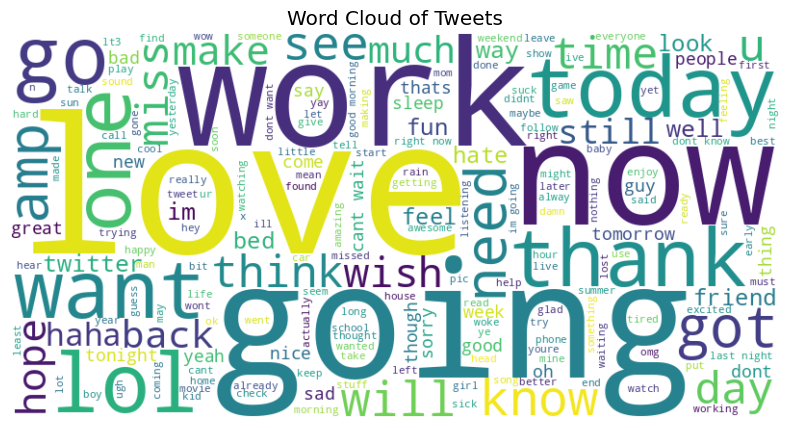

In [167]:
# Combine all the cleaned texts into one string
all_text = ' '.join(df['cleaned_text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for the word cloud
plt.title('Word Cloud of Tweets')
plt.show()

# Define training and evaluation function

In [115]:
def evaluate_model(model, model_name):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
   
    checkpoint = ModelCheckpoint(f'best_{model_name}.keras', monitor='val_accuracy', save_best_only=True)

    history = model.fit(
        X_train, y_train,
        batch_size=64,
        epochs=10,
        validation_split=0.2,
        callbacks=[early_stopping, checkpoint]
    )
    
    # Training metrics
    train_loss, train_accuracy = model.evaluate(X_train, y_train)
    print(f"\n{model_name} Training Accuracy: {train_accuracy:.4f}")
    
    # Test metrics
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
    
    # Predictions and confusion matrix
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(conf_mat=cm, figsize=(10, 10),
                         show_absolute=True,
                         show_normed=True,
                         colorbar=True)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Training History (Loss)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Training History (Accuracy)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return train_accuracy, test_accuracy



# Simple RNN Model   


Training Simple RNN Model...
Epoch 1/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 330s 20ms/step - accuracy: 0.7562 - loss: 0.5023 - val_accuracy: 0.7984 - val_loss: 0.4558
Epoch 2/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 323s 20ms/step - accuracy: 0.8037 - loss: 0.4304 - val_accuracy: 0.7979 - val_loss: 0.4419
Epoch 3/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 322s 20ms/step - accuracy: 0.8122 - loss: 0.4154 - val_accuracy: 0.8042 - val_loss: 0.4233
Epoch 4/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 322s 20ms/step - accuracy: 0.8171 - loss: 0.4074 - val_accuracy: 0.8025 - val_loss: 0.4250
Epoch 5/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 322s 20ms/step - accuracy: 0.8226 - loss: 0.3987 - val_accuracy: 0.8119 - val_loss: 0.4171
Epoch 6/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 322s 20ms/step - accuracy: 0.8239 - loss: 0.3956 - val_accuracy: 0.8088 - val_loss: 0.4186
Epoch 7/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 323s 20ms/step - accuracy: 0.8242 - loss: 0.3948 - val_accuracy: 0.8075 - val_loss: 0.4262
Epoch 8/10
16000/16000 ━━

<Figure size 1000x800 with 0 Axes>

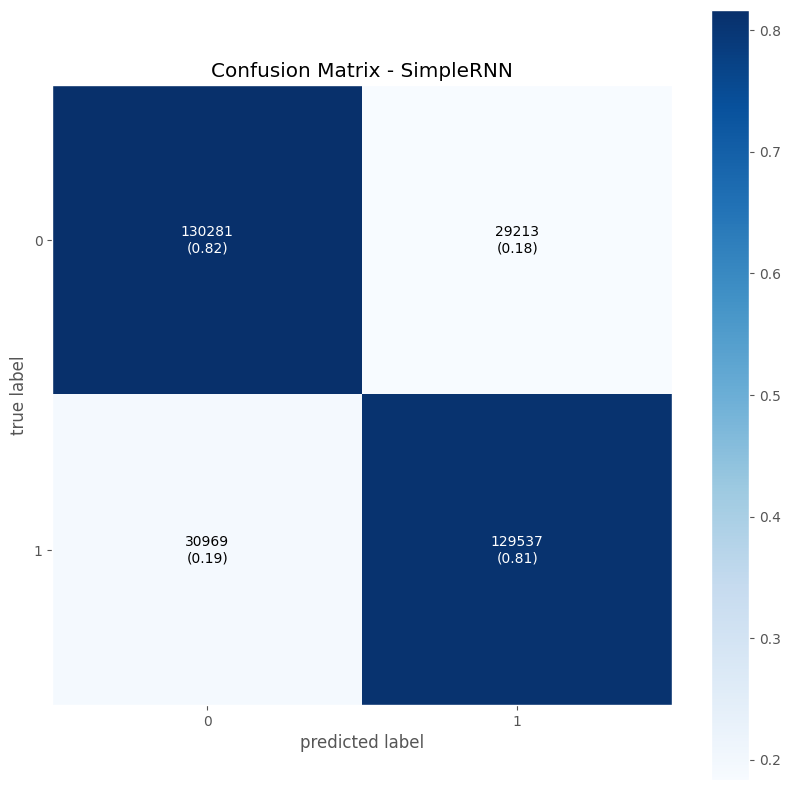

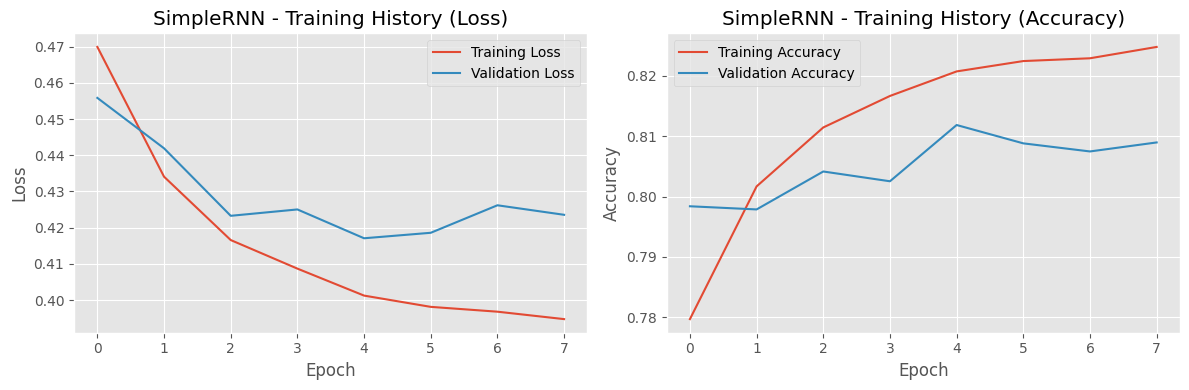

In [30]:
print("\nTraining Simple RNN Model...")
rnn_model = Sequential([
    Input(shape=[max_len]),
    Embedding(max_words, 100, input_length=max_len),
    SimpleRNN(128, return_sequences=True),
    SimpleRNN(64),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
rnn_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
rnn_train_acc, rnn_test_acc = evaluate_model(rnn_model, "SimpleRNN")

#  CNN-LSTM Model


Training CNN-LSTM Model...
Epoch 1/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 251s 15ms/step - accuracy: 0.7876 - loss: 0.4518 - val_accuracy: 0.8170 - val_loss: 0.4000
Epoch 2/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 246s 15ms/step - accuracy: 0.8360 - loss: 0.3701 - val_accuracy: 0.8206 - val_loss: 0.4030
Epoch 3/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 246s 15ms/step - accuracy: 0.8572 - loss: 0.3307 - val_accuracy: 0.8222 - val_loss: 0.3979
Epoch 4/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 246s 15ms/step - accuracy: 0.8757 - loss: 0.2930 - val_accuracy: 0.8199 - val_loss: 0.4179
Epoch 5/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 246s 15ms/step - accuracy: 0.8932 - loss: 0.2583 - val_accuracy: 0.8100 - val_loss: 0.4721
Epoch 6/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 246s 15ms/step - accuracy: 0.9071 - loss: 0.2271 - val_accuracy: 0.8096 - val_loss: 0.4762
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 169s 4ms/step - accuracy: 0.8795 - loss: 0.2917

CNN-LSTM Training Accuracy: 0.8691
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step

<Figure size 1000x800 with 0 Axes>

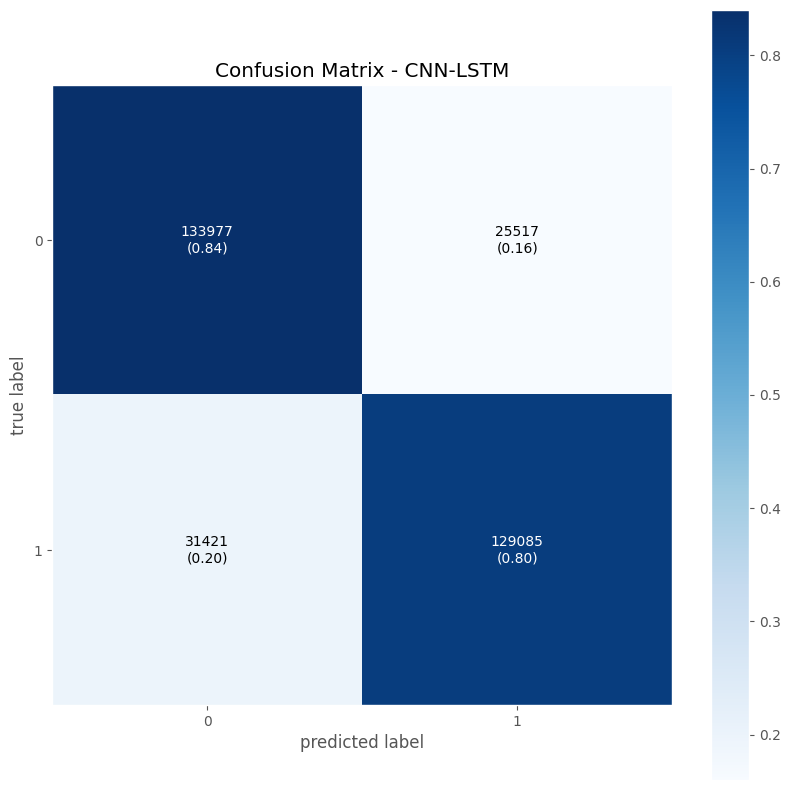

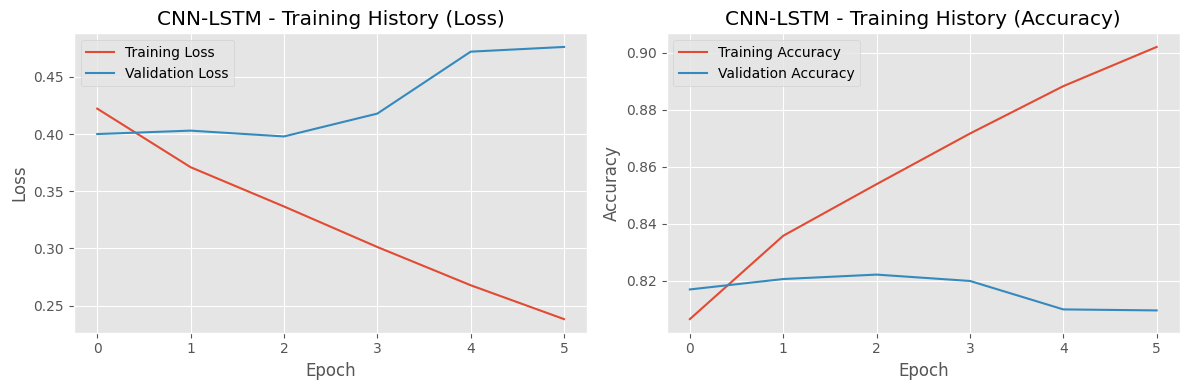

In [32]:
print("\nTraining CNN-LSTM Model...")
cnn_lstm_model = Sequential([
    Input(shape=[max_len]),
    Embedding(max_words, 100, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    Conv1D(128, 5, activation='relu'),
    LSTM(128, return_sequences=True),
    LSTM(64),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
cnn_lstm_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
cnn_lstm_train_acc, cnn_lstm_test_acc = evaluate_model(cnn_lstm_model, "CNN-LSTM")


#  Bidirectional LSTM Model


Training Bidirectional LSTM Model...
Epoch 1/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 409s 25ms/step - accuracy: 0.7856 - loss: 0.4555 - val_accuracy: 0.8204 - val_loss: 0.3963
Epoch 2/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 406s 25ms/step - accuracy: 0.8315 - loss: 0.3783 - val_accuracy: 0.8244 - val_loss: 0.3891
Epoch 3/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 405s 25ms/step - accuracy: 0.8478 - loss: 0.3478 - val_accuracy: 0.8147 - val_loss: 0.4058
Epoch 4/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 405s 25ms/step - accuracy: 0.8622 - loss: 0.3196 - val_accuracy: 0.8248 - val_loss: 0.3993
Epoch 5/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 405s 25ms/step - accuracy: 0.8757 - loss: 0.2913 - val_accuracy: 0.8219 - val_loss: 0.4239
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 292s 7ms/step - accuracy: 0.8490 - loss: 0.3440

BiLSTM Training Accuracy: 0.8444
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 73s 7ms/step - accuracy: 0.8251 - loss: 0.3885
BiLSTM Test Accuracy: 0.8253
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step

Classification R

<Figure size 1000x800 with 0 Axes>

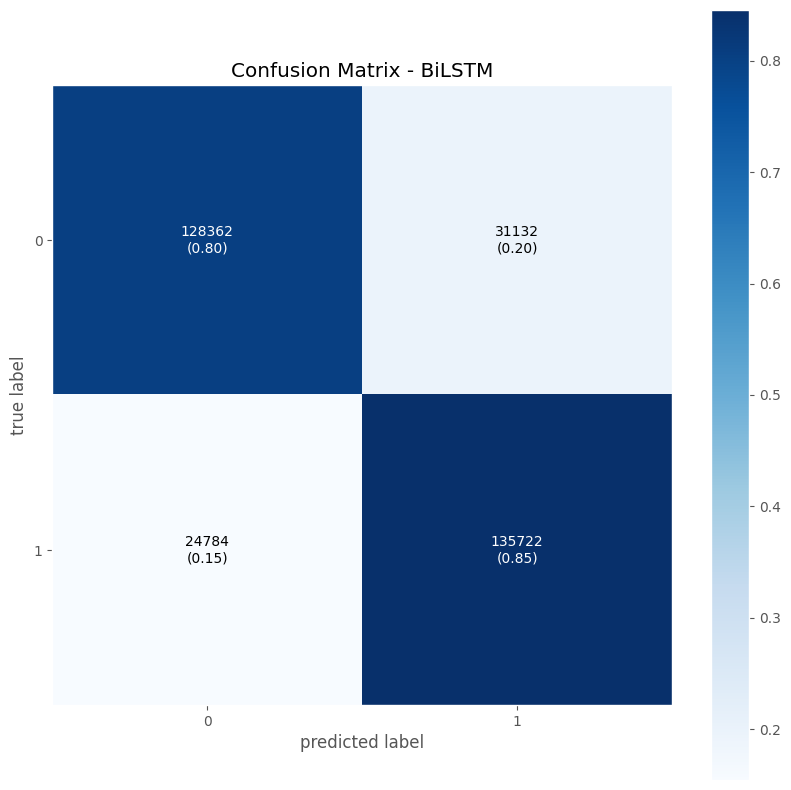

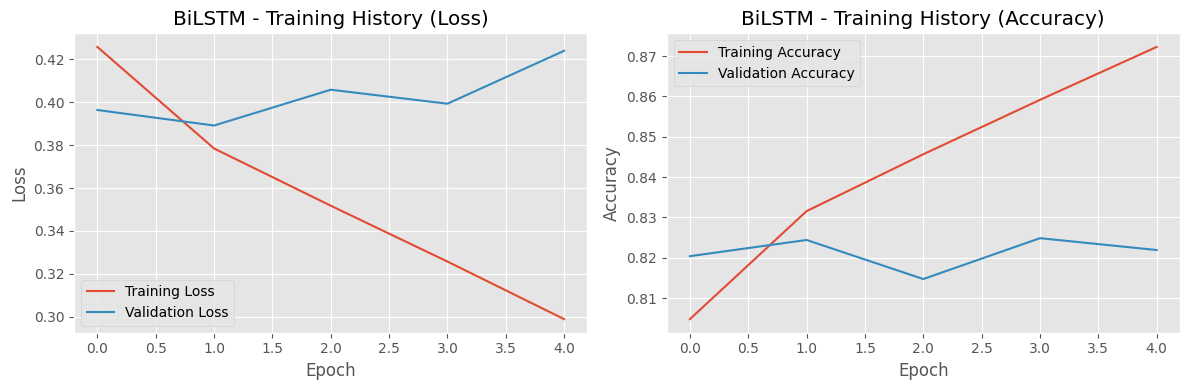

In [35]:
print("\nTraining Bidirectional LSTM Model...")
bilstm_model = Sequential([
    Input(shape=[max_len]),
    Embedding(max_words, 100, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
bilstm_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
bilstm_train_acc, bilstm_test_acc = evaluate_model(bilstm_model, "BiLSTM")


# GRU Model


Training Stacked GRU Model...
Epoch 1/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 203s 13ms/step - accuracy: 0.7843 - loss: 0.4560 - val_accuracy: 0.8147 - val_loss: 0.4043
Epoch 2/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 200s 13ms/step - accuracy: 0.8326 - loss: 0.3765 - val_accuracy: 0.8261 - val_loss: 0.3856
Epoch 3/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 200s 13ms/step - accuracy: 0.8485 - loss: 0.3457 - val_accuracy: 0.8227 - val_loss: 0.3998
Epoch 4/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 200s 12ms/step - accuracy: 0.8613 - loss: 0.3198 - val_accuracy: 0.8250 - val_loss: 0.3952
Epoch 5/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 200s 13ms/step - accuracy: 0.8742 - loss: 0.2941 - val_accuracy: 0.8203 - val_loss: 0.4155
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 164s 4ms/step - accuracy: 0.8511 - loss: 0.3402

StackedGRU Training Accuracy: 0.8465
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.8256 - loss: 0.3863
StackedGRU Test Accuracy: 0.8260
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step

Classification 

<Figure size 1000x800 with 0 Axes>

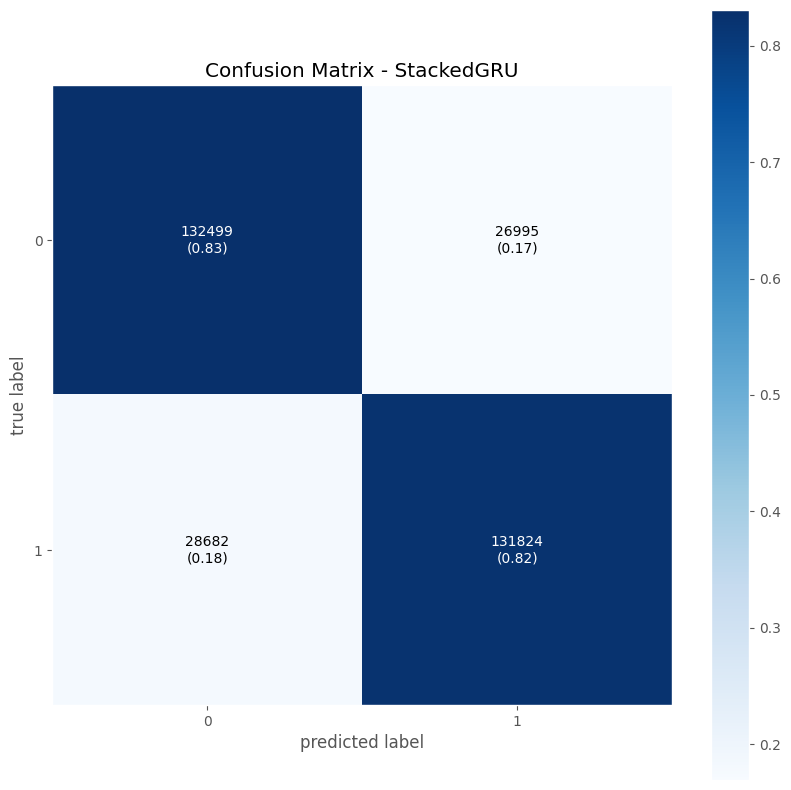

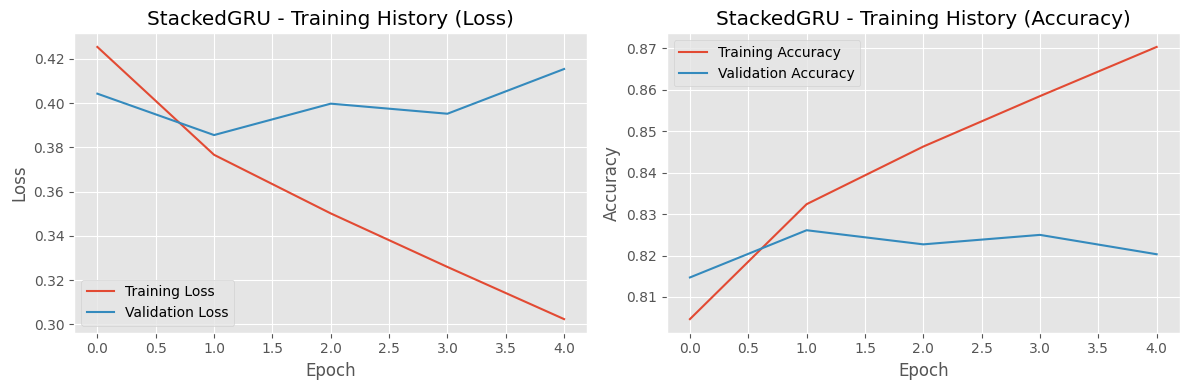

In [37]:
print("\nTraining Stacked GRU Model...")
gru_model = Sequential([
    Input(shape=[max_len]),
    Embedding(max_words, 100, input_length=max_len),
    GRU(128, return_sequences=True),
    GRU(64),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


gru_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
gru_train_acc, gru_test_acc = evaluate_model(gru_model, "StackedGRU")

#  Bidirectional GRU Model


Training Bidirectional GRU Model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 377s 23ms/step - accuracy: 0.7864 - loss: 0.4542 - val_accuracy: 0.7976 - val_loss: 0.4657
Epoch 2/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 375s 23ms/step - accuracy: 0.8324 - loss: 0.3761 - val_accuracy: 0.8242 - val_loss: 0.3886
Epoch 3/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 374s 23ms/step - accuracy: 0.8492 - loss: 0.3449 - val_accuracy: 0.8221 - val_loss: 0.4010
Epoch 4/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 374s 23ms/step - accuracy: 0.8627 - loss: 0.3183 - val_accuracy: 0.8258 - val_loss: 0.3922
Epoch 5/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 374s 23ms/step - accuracy: 0.8761 - loss: 0.2919 - val_accuracy: 0.8220 - val_loss: 0.4105
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 277s 7ms/step - accuracy: 0.8484 - loss: 0.3466

BiGRU Training Accuracy: 0.8443
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 69s 7ms/step - accuracy: 0.8244 - loss: 0.3887
BiGRU Test Accuracy: 0.8247
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step

Classification Report:
              precision    recall

<Figure size 1000x800 with 0 Axes>

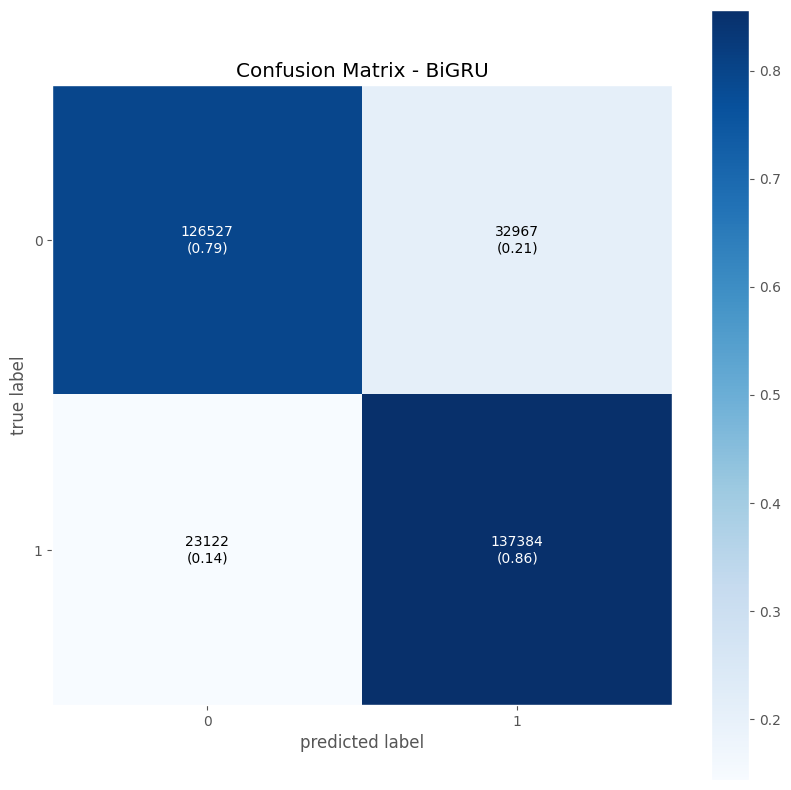

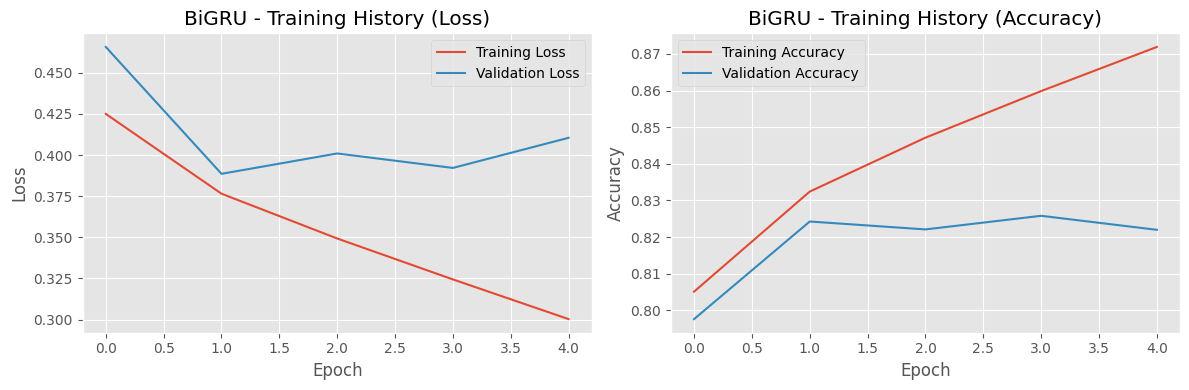

In [38]:
print("\nTraining Bidirectional GRU Model...")
bigru_model = Sequential([
    Input(shape=[max_len]),
    Embedding(max_words, 100, input_length=max_len),
    Bidirectional(GRU(128, return_sequences=True)),
    Bidirectional(GRU(64)),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
bigru_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
bigru_train_acc, bigru_test_acc = evaluate_model(bigru_model, "BiGRU")


#  Transformer Model


Training Transformer Model...
Epoch 1/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 112s 6ms/step - accuracy: 0.7743 - loss: 0.4685 - val_accuracy: 0.8026 - val_loss: 0.4256
Epoch 2/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 97s 6ms/step - accuracy: 0.8110 - loss: 0.4101 - val_accuracy: 0.8090 - val_loss: 0.4163
Epoch 3/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 97s 6ms/step - accuracy: 0.8207 - loss: 0.3930 - val_accuracy: 0.8081 - val_loss: 0.4187
Epoch 4/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 97s 6ms/step - accuracy: 0.8287 - loss: 0.3789 - val_accuracy: 0.8117 - val_loss: 0.4174
Epoch 5/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 97s 6ms/step - accuracy: 0.8377 - loss: 0.3627 - val_accuracy: 0.8088 - val_loss: 0.4250
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step - accuracy: 0.8232 - loss: 0.3879

Transformer Training Accuracy: 0.8208
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.8096 - loss: 0.4171
Transformer Test Accuracy: 0.8097
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step

Classification Report:


<Figure size 1000x800 with 0 Axes>

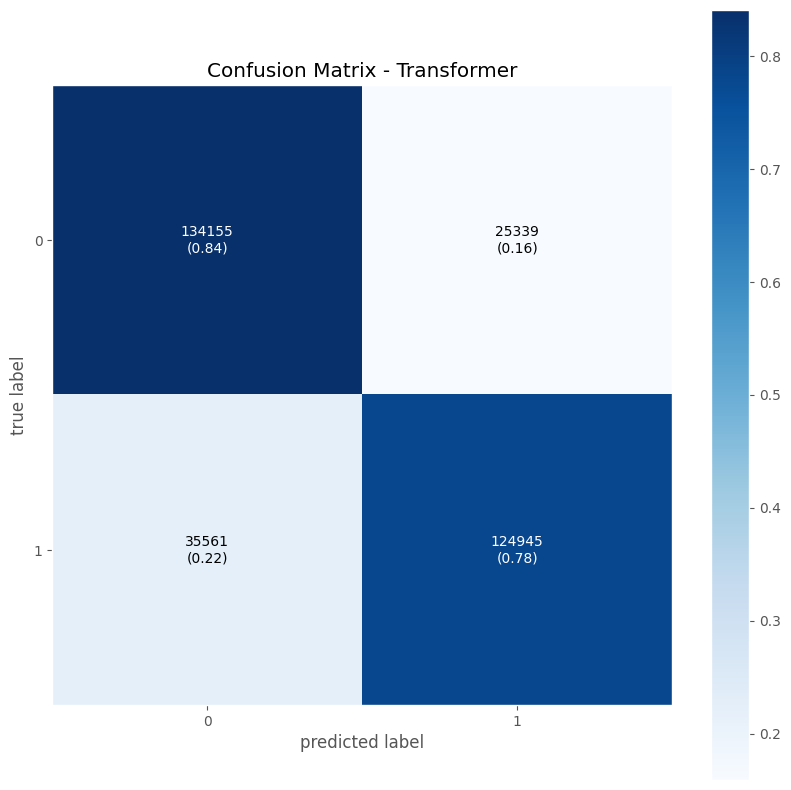

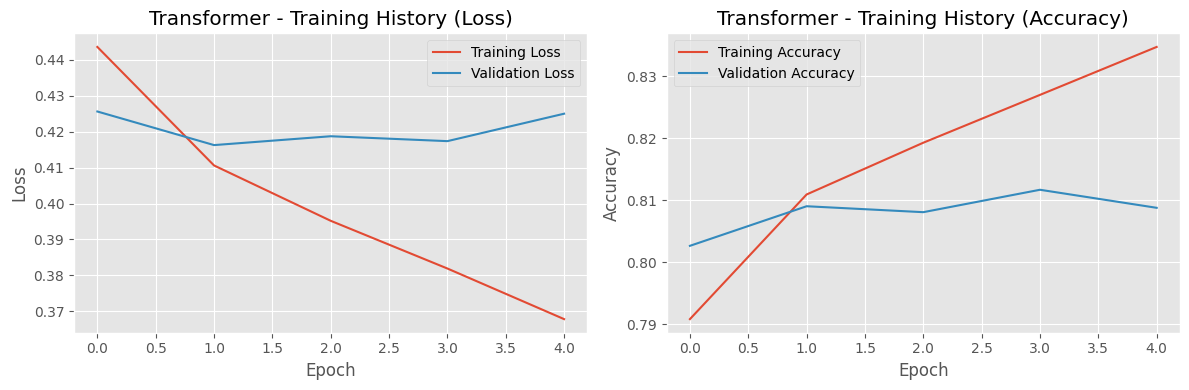

In [40]:
print("\nTraining Transformer Model...")

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):  # Made training parameter optional with default value
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Model construction
inputs = Input(shape=(max_len,))
embedding_layer = Embedding(max_words, 100)(inputs)  # Removed deprecated input_length parameter
transformer_block = TransformerBlock(100, 2, 32)
x = transformer_block(embedding_layer)  # Now works without explicit training parameter
x = GlobalMaxPooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)

transformer_model = Model(inputs=inputs, outputs=outputs)
transformer_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
transformer_train_acc, transformer_test_acc = evaluate_model(transformer_model, "Transformer")

# Compare all models

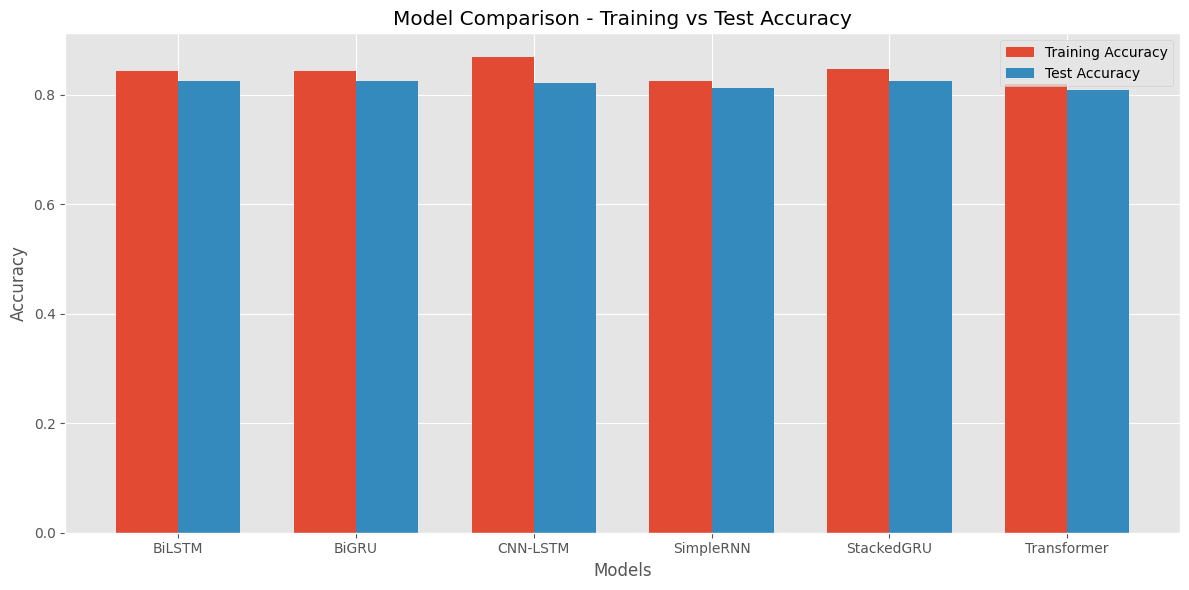


Final Model Comparison:

BiLSTM:
Training Accuracy: 0.8444
Test Accuracy: 0.8253
Difference: 0.0192

BiGRU:
Training Accuracy: 0.8443
Test Accuracy: 0.8247
Difference: 0.0196

CNN-LSTM:
Training Accuracy: 0.8691
Test Accuracy: 0.8221
Difference: 0.0471

SimpleRNN:
Training Accuracy: 0.8251
Test Accuracy: 0.8119
Difference: 0.0132

StackedGRU:
Training Accuracy: 0.8465
Test Accuracy: 0.8260
Difference: 0.0205

Transformer:
Training Accuracy: 0.8208
Test Accuracy: 0.8097
Difference: 0.0112


In [41]:
models = ['BiLSTM', 'BiGRU', 'CNN-LSTM', 'SimpleRNN', 'StackedGRU', 'Transformer']
train_accuracies = [bilstm_train_acc, bigru_train_acc, cnn_lstm_train_acc, 
                   rnn_train_acc, gru_train_acc, transformer_train_acc]
test_accuracies = [bilstm_test_acc, bigru_test_acc, cnn_lstm_test_acc, 
                  rnn_test_acc, gru_test_acc, transformer_test_acc]
plt.figure(figsize=(12, 6))
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, train_accuracies, width, label='Training Accuracy')
plt.bar(x + width/2, test_accuracies, width, label='Test Accuracy')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison - Training vs Test Accuracy')
plt.xticks(x, models)
plt.legend()
plt.tight_layout()
plt.show()

# Print final comparison
print("\nFinal Model Comparison:")
for model, train_acc, test_acc in zip(models, train_accuracies, test_accuracies):
    print(f"\n{model}:")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Difference: {abs(train_acc - test_acc):.4f}")

# TEST

In [163]:
def predict_sentiment(text, model, tokenizer, max_len,clean_tweet):
    cleaned_text = clean_tweet(text)
    text_sequence = tokenizer.texts_to_sequences([cleaned_text])
    text_padded = pad_sequences(text_sequence, maxlen=max_len)

    prediction = model.predict(text_padded, verbose=0)
    sentiment = "Positive" if prediction[0][0] > 0.5 else "Negative"
    confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]

    return sentiment, confidence

# Load the trained BiGRU model
l_model = load_model('best_BiGRU.keras')
print("Model loaded successfully!")

# Example test cases
test_texts = [
    "Absolutely love this product! It's fantastic.",
    "Worst experience ever! Never buying from here again.",
    "Not bad, but could be better.",
    "The service was okay, but the delivery took too long.",
    "Highly recommend this! Great value for money."
]

# Predict sentiment for each text
for text in test_texts:
    sentiment, confidence = predict_sentiment(text, l_model, tokenizer, max_len,clean_tweet)
    print(f"\nText: {text}")
    print(f"Predicted Sentiment: {sentiment} (Confidence: {confidence:.2%})")

# Example usage for new input
new_text = input("\nEnter a new sentence to analyze: ")
sentiment, confidence = predict_sentiment(new_text, l_model, tokenizer, max_len,clean_tweet)
print(f"\nText: {new_text}")
print(f"Predicted Sentiment: {sentiment} (Confidence: {confidence:.2%})")


Model loaded successfully!

Text: Absolutely love this product! It's fantastic.
Predicted Sentiment: Positive (Confidence: 99.35%)

Text: Worst experience ever! Never buying from here again.
Predicted Sentiment: Negative (Confidence: 90.35%)

Text: Not bad, but could be better.
Predicted Sentiment: Positive (Confidence: 76.46%)

Text: The service was okay, but the delivery took too long.
Predicted Sentiment: Negative (Confidence: 79.29%)

Text: Highly recommend this! Great value for money.
Predicted Sentiment: Positive (Confidence: 99.52%)



Enter a new sentence to analyze:  i do not like you



Text: i do not like you
Predicted Sentiment: Negative (Confidence: 60.58%)


In [ ]:
print('hello')